<div class="alert alert-info">

**Note:** vaex.ml is under heavy development, consider this document as a sneak preview.

</div>

# Vaex-ml - Machine Learning
The `vaex.ml` package brings some machine learning algorithms to vaex. Install it by running `pip install vaex-ml`.

Vaex.ml stays close to the authoritative ML package: scikit-learn. We will first show two examples, KMeans and PCA, to see how they compare and differ, and what the gain is in performance.

In [1]:
import vaex.ml.cluster
import vaex.ml.datasets
import numpy as np
%matplotlib inline

We use the well known [iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classical for machine learning.

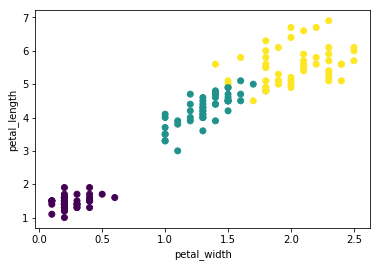

In [6]:
df = vaex.ml.datasets.load_iris()
df.scatter(df.petal_width, df.petal_length, c_expr=df.class_)

In [8]:
df

#,sepal_width,petal_length,sepal_length,petal_width,class_,random_index
0,3.0,4.2,5.9,1.5,1,114
1,3.0,4.6,6.1,1.4,1,74
2,2.9,4.6,6.6,1.3,1,37
3,3.3,5.7,6.7,2.1,2,116
4,4.2,1.4,5.5,0.2,0,61
...,...,...,...,...,...,...
145,3.4,1.4,5.2,0.2,0,119
146,3.8,1.6,5.1,0.2,0,15
147,2.6,4.0,5.8,1.2,1,22
148,3.8,1.7,5.7,0.3,0,144


## KMeans
We use two features to do a KMeans, and roughly put the two features on the same scale by a simple division. We then construct a KMeans object, quite similar to what you would do in [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), and fit it.

In [10]:
features = ['petal_width/2', 'petal_length/5']
init = [[0, 1/5], [1.2/2, 4/5], [2.5/2, 6/5]] # 
kmeans = vaex.ml.cluster.KMeans(features=features, init=init, verbose=True)
kmeans.fit(df)

Iteration    0, inertia  6.2609999999999975
Iteration    1, inertia  2.5062184444444435
Iteration    2, inertia  2.443455900151798
Iteration    3, inertia  2.418136327962199
Iteration    4, inertia  2.4161501474358995
Iteration    5, inertia  2.4161501474358995


We now transform the original DataFrame, similar to sklearn. However, we now end up with a new DataFrame, which contains an extra column (prediction_kmeans).

In [11]:
df_predict = kmeans.transform(df)
df_predict

#,sepal_width,petal_length,sepal_length,petal_width,class_,random_index,prediction_kmeans
0,3.0,4.2,5.9,1.5,1,114,1
1,3.0,4.6,6.1,1.4,1,74,1
2,2.9,4.6,6.6,1.3,1,37,1
3,3.3,5.7,6.7,2.1,2,116,2
4,4.2,1.4,5.5,0.2,0,61,0
...,...,...,...,...,...,...,...
145,3.4,1.4,5.2,0.2,0,119,0
146,3.8,1.6,5.1,0.2,0,15,0
147,2.6,4.0,5.8,1.2,1,22,1
148,3.8,1.7,5.7,0.3,0,144,0


Although this column is special, it is actually a virtual column, it does not use up any memory and will be computed on the fly when needed, saving us precious ram. Note that the other columns reference the original data as well, so this new DataFrame (ds_predict) almost takes up no memory at all, which is ideal for very large datasets, and quite different from what sklearn will do.

In [12]:
df_predict.virtual_columns['prediction_kmeans']

'kmean_predict_function(petal_width/2, petal_length/5)'

By making a simple scatter plot we can see the KMeans does a pretty good job.

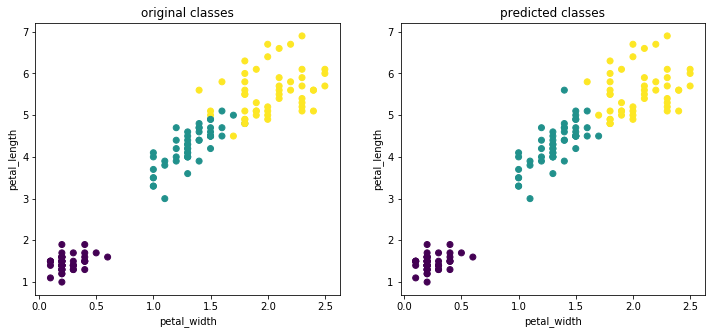

In [16]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(1, 2, figsize=(12,5))

plt.sca(ax[0])
plt.title('original classes')
df.scatter(df.petal_width, df.petal_length, c_expr=df.class_)

plt.sca(ax[1])
plt.title('predicted classes')
df_predict.scatter(df_predict.petal_width, df_predict.petal_length, c_expr=df_predict.prediction_kmeans)

## KMeans benchmark
To demonstrate the performance and scaling of vaex, we continue with a special version of the iris dataset that has $\sim10^7$ rows, by repeating the rows many times.

In [28]:
df = vaex.ml.datasets.load_iris_1e7()

We now use random initial conditions, and execute 10 runs in parallel (n_init), for a maximum of 5 iterations and benchmark it.

In [29]:
features = ['petal_width/2', 'petal_length/5']
kmeans = vaex.ml.cluster.KMeans(features=features, n_clusters=3, init='random', random_state=1,
                                max_iter=5, verbose=True, n_init=10)

In [30]:
%%timeit -n1 -r1 -o
kmeans.fit(df)

Iteration    0, inertia  1784973.7999986452 |  1548329.799999016 |  354711.39999875583 |  434173.39999885217 |  1005871.0000026902 |  1312114.6000003854 |  1989377.3999927905 |  577104.4999989534 |  2747388.6000027955 |  628486.7999971791
Iteration    1, inertia  481645.0225601919 |  233311.807648651 |  214794.26525253727 |  175205.9965848818 |  490218.5413715277 |  816598.0811733825 |  285786.2566865457 |  456305.0601529535 |  1205488.9851008556 |  262443.28449456714
Iteration    2, inertia  458443.873920266 |  162015.13397359708 |  173081.69460305249 |  162580.06671935317 |  488402.97447322187 |  436698.8939923954 |  162626.5498899455 |  394680.5108569788 |  850103.6561417003 |  198213.0961053151
Iteration    3, inertia  394680.5108569788 |  161882.05987810466 |  162580.0667193532 |  161882.05987810466 |  487435.98983613256 |  214098.28159484005 |  161882.05987810466 |  275282.3731570135 |  594451.8937940609 |  169525.19719336918
Iteration    4, inertia  275282.3731570135 |  161882.0

<TimeitResult : 3.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [31]:
time_vaex = _

We now do the same using sklearn.

In [32]:
from sklearn.cluster import KMeans
kmeans_sk = kmeans = KMeans(n_clusters=3, init='random', max_iter=5, verbose=True, algorithm='full', n_jobs=-1,
                           precompute_distances=False, n_init=10)
# Doing an unfortunate memory copy
X = np.array(df[features])

In [33]:
%%timeit -n1 -r1 -o
kmeans_sk.fit(X)

Initialization complete
Iteration  0, inertia 538264.600
Iteration  1, inertia 488488.457
Iteration  2, inertia 477825.973
Iteration  3, inertia 458443.874
Iteration  4, inertia 394680.511
Initialization complete
Iteration  0, inertia 1478542.600
Iteration  1, inertia 488488.457
Iteration  2, inertia 477825.973
Iteration  3, inertia 458443.874
Iteration  4, inertia 394680.511
Initialization complete
Iteration  0, inertia 422756.600
Iteration  1, inertia 182182.175
Iteration  2, inertia 164120.408
Iteration  3, inertia 162023.380
Iteration  4, inertia 161882.060
Converged at iteration 4: center shift 0.000000e+00 within tolerance 1.341649e-05
Initialization complete
Iteration  0, inertia 1873065.400
Iteration  1, inertia 260752.951
Iteration  2, inertia 161882.060
Converged at iteration 2: center shift 0.000000e+00 within tolerance 1.341649e-05
Initialization complete
Iteration  0, inertia 808489.000
Iteration  1, inertia 275282.373
Iteration  2, inertia 201144.261
Iteration  3, inertia

<TimeitResult : 46.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [34]:
time_sklearn = _

We see that vaex is quite fast:

In [35]:
print('vaex is approx', time_sklearn.best / time_vaex.best, 'times faster for KMeans')

vaex is approx 11.77461207454833 times faster for KMeans


But also, sklean will need to copy the data, while vaex will be very careful not to do unnecessary copies, and minimal amounts of passes of the data (Out-of-core). Therefore vaex will happily scale to massive datasets, while with sklearn you will be limited to the size of the RAM.

## PCA Benchmark
We now continue with benchmarking a PCA on 4 features:

In [36]:
features = [k.expression for k in [df.col.petal_width, df.col.petal_length, df.col.sepal_width, df.col.sepal_length]]
pca = df.ml.pca(features=features)

In [37]:
%%timeit -n1 -r3 -o
pca = df.ml.pca(features=features)

226 ms ± 30.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 226 ms ± 30.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [38]:
time_vaex = _

Since sklearn takes too much memory with this dataset, we only use 10% for sklearn, and correct later.

In [40]:
# on my laptop this takes too much memory with sklearn, use only a subset
factor = 0.1
df.set_active_fraction(factor)
len(df)

1005000

In [41]:
from sklearn.decomposition import PCA
pca_sk = PCA(n_components=2, random_state=33, svd_solver='full', whiten=False)
X = np.array(df.trim()[features])

In [42]:
%%timeit -n1 -r3 -o
pca_sk.fit(X)

130 ms ± 25 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


<TimeitResult : 130 ms ± 25 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)>

In [43]:
time_sklearn = _

In [44]:
print('vaex is approx', time_sklearn.best / time_vaex.best / factor, 'times faster for a PCA')

vaex is approx 5.4043995278391295 times faster for a PCA


Again we see that vaex not only will outperform sklearn, but more importantly it will scale to much larger datasets.

## A billion row PCA
We now run a PCA on **a billion rows**.

In [51]:
df_big = vaex.ml.datasets.load_iris_1e9()

In [52]:
%%timeit -n1 -r2 -o
pca = df_big.ml.pca(features=features)

3min 9s ± 20.5 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


<TimeitResult : 3min 9s ± 20.5 s per loop (mean ± std. dev. of 2 runs, 1 loop each)>

Note the although this dataset is $10\times$ larger, it takes more than $10\times$ to execute. This is because this dataset did not fit into memory this time, and is limited to the harddrive speed. But note that it *possible* to actually run it, instead of giving a MemoryError!

## XGBoost
This example shows integration with xgboost, this is work in progress.

In [2]:
import vaex.ml.xgboost

In [3]:
df = vaex.ml.datasets.load_iris()

In [4]:
features = [k.expression for k in [df.col.petal_width, df.col.petal_length, df.col.sepal_width, df.col.sepal_length]]

In [6]:
df_train, df_test = df.ml.train_test_split(verbose=False)

In [7]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
xgmodel = vaex.ml.xgboost.XGBoostModel(features=features, num_boost_round=10, params=params)

In [9]:
xgmodel.fit(df_train, df_train.class_)

In [10]:
df_predict = xgmodel.transform(df_test)
df_predict

#,sepal_length,sepal_width,petal_length,petal_width,class_,xgboost_prediction
0,5.9,3.0,4.2,1.5,1,1.0
1,6.1,3.0,4.6,1.4,1,1.0
2,6.6,2.9,4.6,1.3,1,1.0
3,6.7,3.3,5.7,2.1,2,2.0
4,5.5,4.2,1.4,0.2,0,0.0
...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,1.0
26,5.8,2.7,3.9,1.2,1,1.0
27,4.4,2.9,1.4,0.2,0,0.0
28,4.5,2.3,1.3,0.3,0,0.0


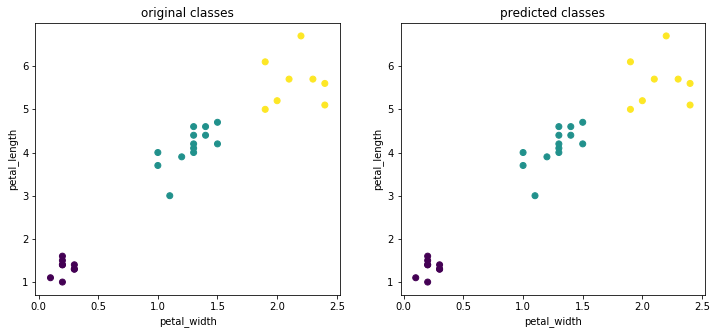

In [11]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(1, 2, figsize=(12,5))

plt.sca(ax[0])
plt.title('original classes')
df_predict.scatter(df_predict.petal_width, df_predict.petal_length, c_expr=df_predict.class_)

plt.sca(ax[1])
plt.title('predicted classes')
df_predict.scatter(df_predict.petal_width, df_predict.petal_length, c_expr=df_predict.xgboost_prediction)

## One hot encoding
Shortly showing one hot encoding

In [27]:
encoder = df.ml.one_hot_encoder([df.col.class_])
df_encoded = encoder.transform(df)

In [28]:
df_encoded

#,sepal_width,petal_length,sepal_length,petal_width,class_,random_index,class__0,class__1,class__2
0,3.0,4.2,5.9,1.5,1,114,0,1,0
1,3.0,4.6,6.1,1.4,1,74,0,1,0
2,2.9,4.6,6.6,1.3,1,37,0,1,0
3,3.3,5.7,6.7,2.1,2,116,0,0,1
4,4.2,1.4,5.5,0.2,0,61,1,0,0
...,...,...,...,...,...,...,...,...,...
145,3.4,1.4,5.2,0.2,0,119,1,0,0
146,3.8,1.6,5.1,0.2,0,15,1,0,0
147,2.6,4.0,5.8,1.2,1,22,0,1,0
148,3.8,1.7,5.7,0.3,0,144,1,0,0
